In [42]:
from models import UMNNMAFFlow
import torch
from torch.utils.data import DataLoader
from torch.distributions.multivariate_normal import MultivariateNormal
import lib.toy_data as toy_data
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import os
import lib.utils as utils
import lib.visualize_flow as vf

In [34]:
device = "cpu"

# Dataset 

In [35]:
toy_dataset = "8gaussians"

In [36]:
batch_size = 100
num_data = 10000

x_train = torch.tensor(toy_data.inf_train_gen(toy_dataset, batch_size=num_data)).to(device)
x_test = torch.tensor(toy_data.inf_train_gen(toy_dataset, batch_size=1000)).to(device)

x_train = DataLoader(x_train, batch_size=batch_size)
x_test = DataLoader(x_test, batch_size=batch_size)

# Model

In [37]:
nb_steps=20
nb_flow=1

model = UMNNMAFFlow(nb_flow=nb_flow, 
                    nb_in=2, 
                    hidden_derivative=[100, 100, 100, 100], 
                    hidden_embedding=[100, 100, 100, 100],
                    embedding_s=10, 
                    nb_steps=nb_steps, 
                    device=device).to(device)

# Training

In [38]:
opt = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-5)

epoch: 0 - Train loss: 3.861631 - Test loss: 3.325110


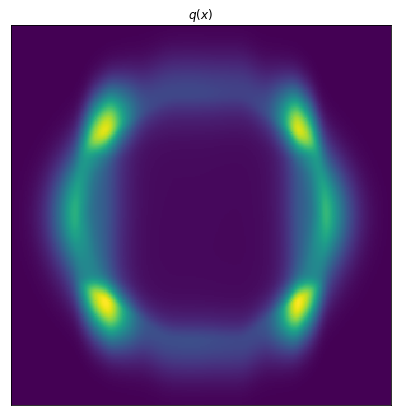

epoch: 10 - Train loss: 2.831261 - Test loss: 2.894772


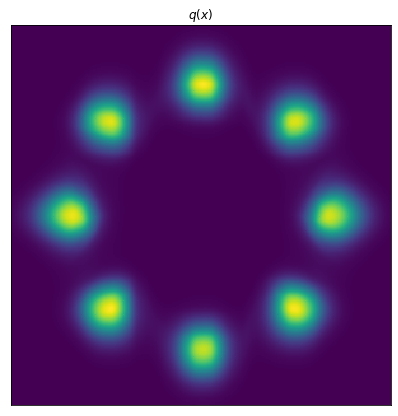

epoch: 20 - Train loss: 2.825982 - Test loss: 2.903662


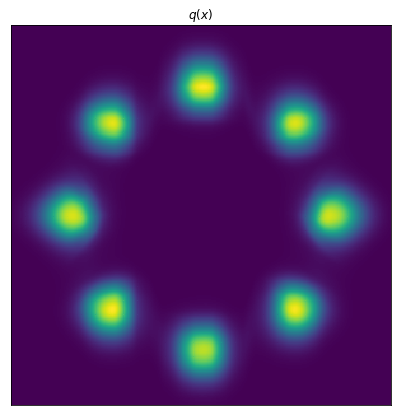

epoch: 30 - Train loss: 2.824440 - Test loss: 2.895004


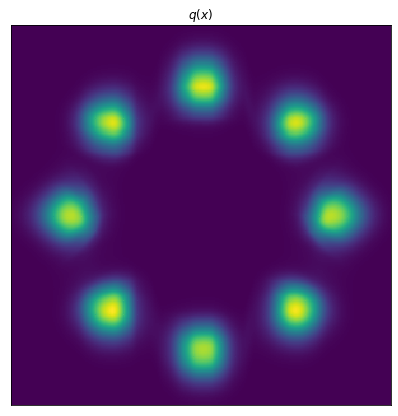

epoch: 40 - Train loss: 2.824718 - Test loss: 2.886171


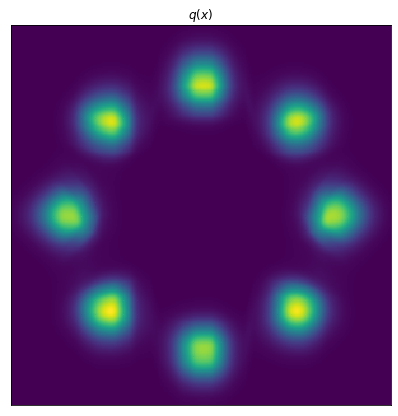

epoch: 50 - Train loss: 2.819875 - Test loss: 2.882797


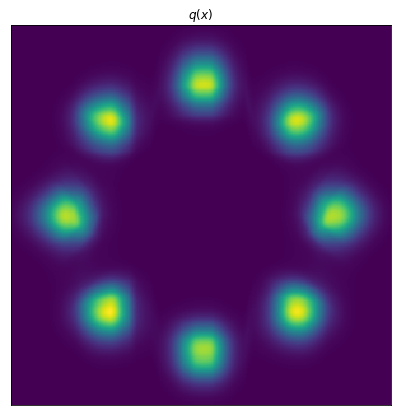

epoch: 60 - Train loss: 2.818455 - Test loss: 2.881660


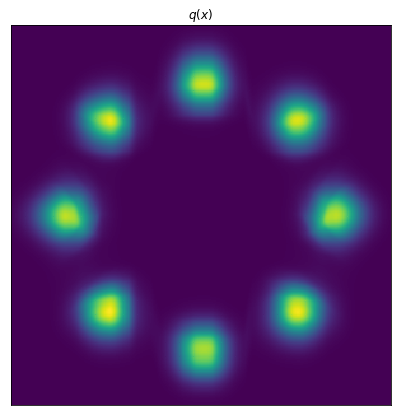

epoch: 70 - Train loss: 2.817491 - Test loss: 2.881994


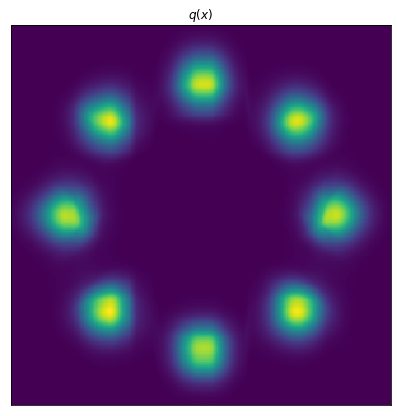

epoch: 80 - Train loss: 2.817403 - Test loss: 2.883381


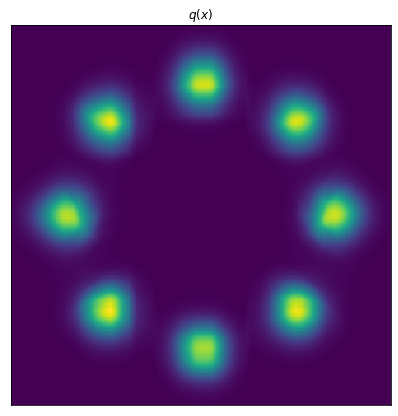

epoch: 90 - Train loss: 2.815804 - Test loss: 2.883099


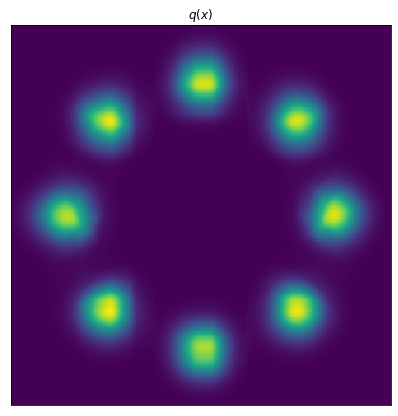

In [39]:
print_every = 10
nb_epoch = 100
training_loss = []
testing_loss = []

for epoch in range(nb_epoch):
    
    # Training
    train_loss = 0    
    for batch in x_train:
        ll, z = model.compute_ll(batch)
        ll = -ll.mean()
        train_loss += ll.detach()/(batch_size/batch.shape[0])/len(x_train)
        loss = ll
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    # Compute Test Loss    
    test_loss = 0  
    for batch in x_test:
        ll_test, _ = model.compute_ll(batch)
        ll_test = -ll_test.mean()
        test_loss += ll_test.detach()/(batch_size/batch.shape[0])/len(x_test)
    
    training_loss.append(train_loss)
    testing_loss.append(test_loss)

    if (epoch % print_every) == 0:
        print("epoch: {:d} - Train loss: {:4f} - Test loss: {:4f}".
                format(epoch, train_loss.item(), test_loss.item()))
        
        fig = plt.figure(figsize=(7, 7))
        ax = plt.subplot(1, 1, 1, aspect="equal")
        vf.plt_flow(model.compute_ll, ax)
        plt.show()

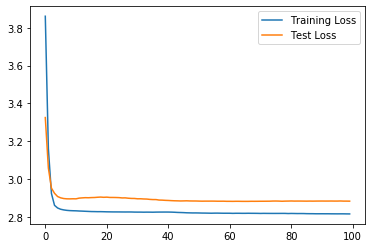

In [40]:
plt.plot(training_loss, label='Training Loss')
plt.plot(testing_loss, label='Test Loss')
plt.legend()

# Sample from the model

In [43]:
def sample_p_z(size, dim=2):
    means =  torch.zeros(size, dim)
    cov =  torch.eye(dim)
    
    m = MultivariateNormal(means, cov)
    return m.sample()

In [48]:
z1 = sample_p_z(1000)
z2 = sample_p_z(1000)
x = model.invert(z)

0


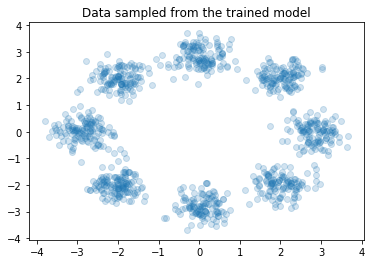

In [57]:
plt.scatter(x[:, 0], x[:, 1], alpha=0.2);
plt.title('Data sampled from the trained model');